In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path

DATA_PATH = Path("datasets/CMaps/")
images_dir = "images"

indexes = ['unit_number', 'time_cycles']
settings = ['setting_1', 'setting_2', 'setting_3']
sensors = ['s_{}'.format(i+1) for i in range(0,21)]
COLS = indexes + settings + sensors

In [2]:
Sensor_dictionary = {}
dict_list = [
    "Fan intake temperature (°R)",
    "Low-Pressure Compressor outlet temperature (°R)",
    "High-Pressure Compressor outlet temperature (°R)",
    "Low-Pressure Turbine outlet temperature (°R)",
    "Fan intake pressure (psia)",
    "Bypass-duct pressure (psia)",
    "High-Pressure Compressor outlet pressure (psia)",
    "Physical fan RPM",
    "Physical core RPM",
    "Engine pressure ratio (P50/P2)",
    "High-Pressure Compressor outlet static pressure (psia)",
    "Fuel flow to Ps30 ratio (pps/psia)",
    "Corrected fan RPM",
    "Corrected core RPM",
    "Bypass ratio",
    "Burner fuel-air ratio",
    "Bleed enthalpy",
    "Required fan RPM",
    "Required fan conversion RPM",
    "High-pressure turbine cooling airflow",
    "Low-pressure turbine cooling airflow"
]

Sensor_dictionary = {f's_{i+1}': sensor for i, sensor in enumerate(dict_list)}
Sensor_dictionary

def load_fd_dataset(dataset_id):

    train_file = DATA_PATH / f"train_FD00{dataset_id}.txt"
    test_file  = DATA_PATH / f"test_FD00{dataset_id}.txt"
    rul_file   = DATA_PATH / f"RUL_FD00{dataset_id}.txt"

    df_train = pd.read_csv(
        train_file,
        sep=r"\s+",        
        header=None,
        names=COLS,
        index_col=False
    )

    df_test = pd.read_csv(
        test_file,
        sep=r"\s+",
        header=None,
        names=COLS,
        index_col=False
    )

    df_rul = pd.read_csv(
        rul_file,
        sep=r"\s+",
        header=None,
        names=["RUL"],
        index_col=False
    )
    
    return df_train, df_test, df_rul

def add_train_rul(df_train):
    # Group by unit and get the max cycle of each engine
    max_cycle = df_train.groupby("unit_number")["time_cycles"].transform("max")
    # RUL = distance to max cycle
    df_train["RUL"] = max_cycle - df_train["time_cycles"]
    return df_train

def add_test_rul(df_test, df_rul):

    idx = df_test.groupby("unit_number")["time_cycles"].transform("max") == df_test["time_cycles"]
    final_test_rows = df_test[idx].copy().reset_index(drop=True)
    final_test_rows["RUL"] = df_rul["RUL"]
    
    return final_test_rows

In [3]:
datasets = {}  

for i in range(1, 5):
    
    df_train_raw, df_test_raw, df_rul = load_fd_dataset(i)
    df_train = add_train_rul(df_train_raw)
    df_test_final = add_test_rul(df_test_raw, df_rul)
    key = f"FD00{i}"
    datasets[key] = {
        "train":       df_train,   
        "test":        df_test_raw,
        "rul":         df_rul,
        "test_final":  df_test_final,
    }

# Gradient Boosting

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 41.785944658276584
MAE: 29.809532045612173
R²: 0.6178280874195339


This is the simplest gradient boost evulation with no added features or methods to see what it looks on basic.

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


df_fd001 = datasets["FD001"]["train"]

# Drop unnecessary columns
drop_cols = ["unit_number", "time_cycles", "RUL", "s_1", "s_5", "s_6", "s_10", "s_16", "s_18", "s_19"]
feature_cols = [col for col in df_fd001.columns if col not in drop_cols]
X = df_fd001[feature_cols]
y = df_fd001["RUL"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

RMSE: 41.840833984811596
MAE: 29.867755691814914
R²: 0.6168233985607092


After we do dropping some slightly unhelpful columns our values worsen somehow so it not may be best to not drop those columns.

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)


y_pred = gbr.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 41.76937208575973
MAE: 29.800250099574008
R²: 0.618131170947712


We can see scaling helps with results so it will be used

In [7]:
""" import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up the hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 1000),  # number of trees
    'learning_rate': uniform(0.01, 0.2),  # learning rate
    'max_depth': randint(3, 10),  # max depth of the trees
    'min_samples_split': randint(2, 10),  # min samples to split
    'min_samples_leaf': randint(1, 10),  # min samples to be at a leaf node
    'subsample': uniform(0.5, 0.5)  # fraction of samples to use for fitting each tree
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbr, param_distributions=param_dist, 
    n_iter=50,  # number of different combinations to try
    scoring='neg_mean_squared_error',  # use negative MSE for scoring (as lower is better)
    cv=5,  # 5-fold cross-validation
    verbose=1,  # print progress
    random_state=42,
    n_jobs=-1  # use all available cores for computation
)

# Run the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the random search
best_gbr = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_gbr.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 """

' import numpy as np\nimport pandas as pd\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split, RandomizedSearchCV\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom scipy.stats import uniform, randint\n\n# Prepare features and target\ndf_fd001 = datasets["FD001"]["train"]\nX = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])\ny = df_fd001["RUL"]\n\n# Split into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Initialize the Gradient Boosting Regressor\ngbr = GradientBoostingRegressor(random_state=42)\n\n# Set up the hyperparameter search space\nparam_dist = {\n    \'n_estimators\': randint(100, 1000),  # number of trees\n    \'learning_rate\': uniform(0.01, 0.2),  # learning rate\n    \'max_depth\': randint(3, 10),  # max depth of the trees\n    \'min_samples_split\': randint(2, 10),  # min samples to split\n  

This is used grid search to see best hyperparameters to see what values are best. Which with the best model resluts will be used on next part.

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


df_fd001 = datasets["FD001"]["train"]


X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize model with best found hyperparameters
gbr = GradientBoostingRegressor(
    learning_rate=0.010155753168202867,
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=559,
    subsample=0.8058265802441404,
    random_state=42
)


gbr.fit(X_train, y_train)


y_pred = gbr.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 41.01073497313826
MAE: 29.34156323192828
R²: 0.6318766026617582


After using best hyperparameters we found on GridSearch and use Scaling combined we get best results yet

# XG BOOST

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


df_fd001 = datasets["FD001"]["train"]

# Features and target
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',   
    verbosity=0,
    n_jobs=-1
)


xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)


y_pred = xgb_model.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("XGBoost Evaluation:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

XGBoost Evaluation:
RMSE: 40.99288953205787
MAE: 29.305639266967773
R²: 0.6321969032287598


# CatBoost

In [10]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=5,
    random_seed=42,
    verbose=0  
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred = cat_model.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("CatBoost Evaluation:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


CatBoost Evaluation:
RMSE: 41.03782952975217
MAE: 29.470129970663912
R²: 0.6313900259133265


# HISTORICAL DATA

FD001 Gradient Boosting Regressor Results:
Mean Absolute Error (MAE): 20.483950091982333
Root Mean Squared Error (RMSE): 27.981117361656977


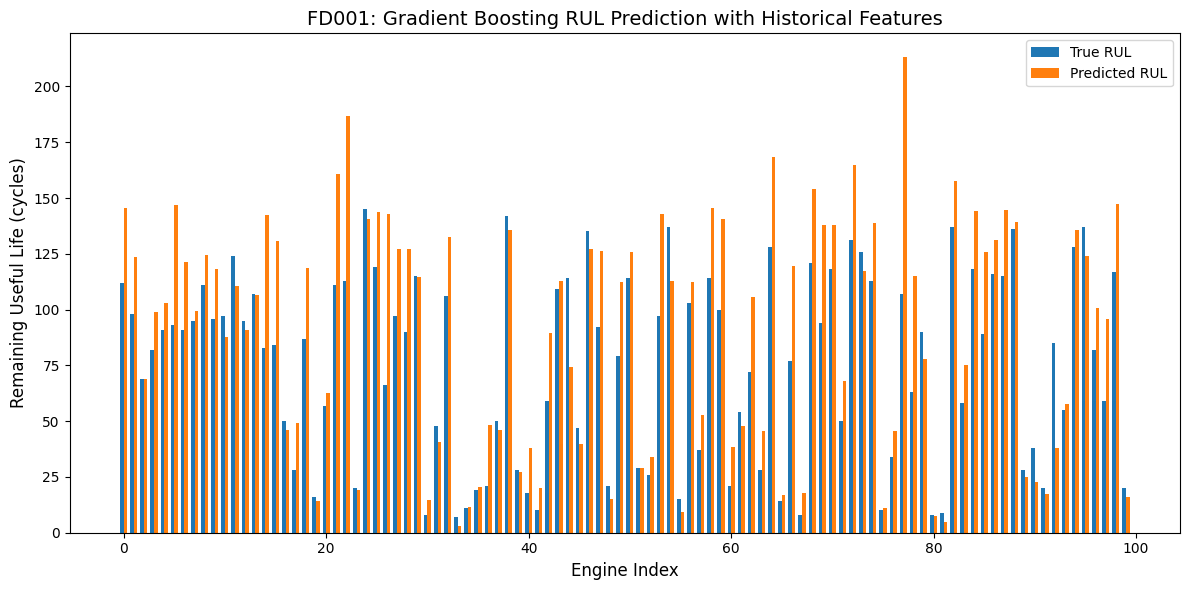

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dataset loading 
gb_train = datasets["FD001"]["train"]
gb_test = datasets["FD001"]["test"]
gb_RUL = datasets["FD001"]["rul"]

# Historical feature creation functions
def create_history_features(df, feature_cols, window_size):
    X_hist = []
    y_hist = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) < window_size:
            continue
        for i in range(window_size - 1, len(group)):
            window_data = group.iloc[i - window_size + 1 : i + 1][feature_cols].values
            window_flat = window_data.flatten()
            target = group.iloc[i]["RUL"]
            X_hist.append(window_flat)
            y_hist.append(target)
    return np.array(X_hist), np.array(y_hist)

def create_test_history_features(df, feature_cols, window_size):
    X_test_hist = []
    unit_ids = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) >= window_size:
            window_data = group.iloc[-window_size:][feature_cols].values
            window_flat = window_data.flatten()
            X_test_hist.append(window_flat)
            unit_ids.append(unit)
    return np.array(X_test_hist), unit_ids

# Window size
window_size = 20

# Define feature columns 
feature_cols = [col for col in gb_train.columns if col not in ["unit_number", "time_cycles", "RUL"]]

# Create train/test sets
X_train_hist, y_train_hist = create_history_features(gb_train, feature_cols, window_size)
X_test_hist, test_unit_ids = create_test_history_features(gb_test, feature_cols, window_size)
y_test = gb_RUL["RUL"].values

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    subsample=0.8
)
gbr.fit(X_train_scaled, y_train_hist)

# Predict and evaluate
y_pred = gbr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FD001 Gradient Boosting Regressor Results:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Bar chart
n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: Gradient Boosting RUL Prediction with Historical Features", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


FD001 XGBoost Regressor Results with Fixed Hyperparameters:
Mean Absolute Error (MAE): 19.528961181640625
Root Mean Squared Error (RMSE): 26.353887849521488
R² Score: 0.5978112816810608


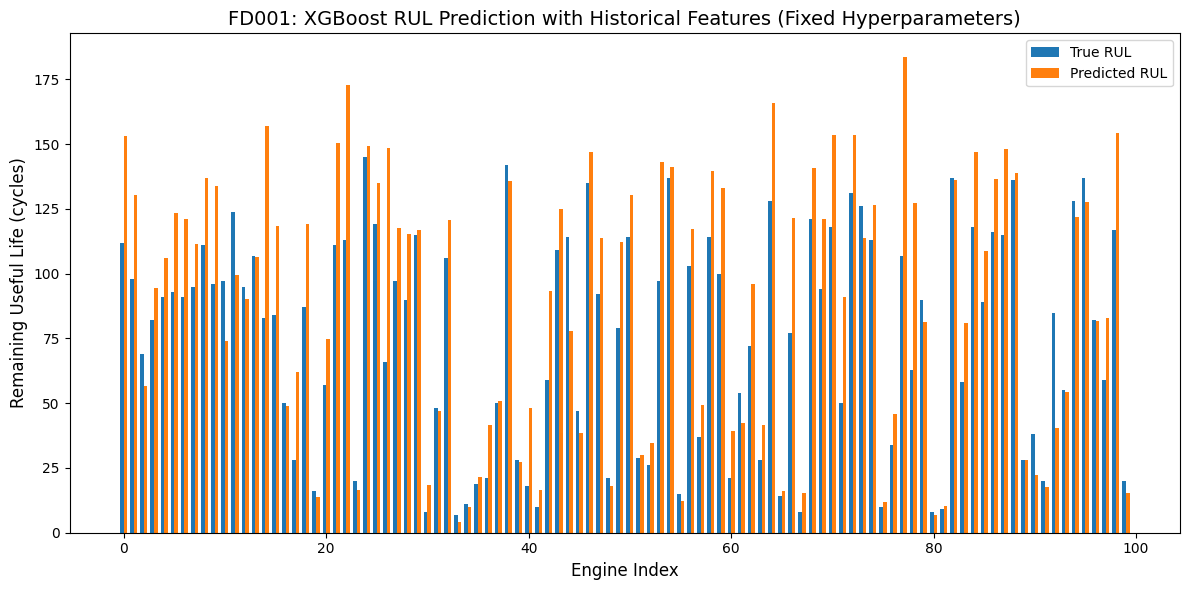

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Dataset loading 
gb_train = datasets["FD001"]["train"]
gb_test = datasets["FD001"]["test"]
gb_RUL = datasets["FD001"]["rul"]

# Historical feature creation functions 
def create_history_features(df, feature_cols, window_size):
    X_hist = []
    y_hist = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) < window_size:
            continue
        for i in range(window_size - 1, len(group)):
            window_data = group.iloc[i - window_size + 1 : i + 1][feature_cols].values
            window_flat = window_data.flatten()
            target = group.iloc[i]["RUL"]
            X_hist.append(window_flat)
            y_hist.append(target)
    return np.array(X_hist), np.array(y_hist)

def create_test_history_features(df, feature_cols, window_size):
    X_test_hist = []
    unit_ids = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) >= window_size:
            window_data = group.iloc[-window_size:][feature_cols].values
            window_flat = window_data.flatten()
            X_test_hist.append(window_flat)
            unit_ids.append(unit)
    return np.array(X_test_hist), unit_ids

# Window size
window_size = 20

# Define feature columns 
feature_cols = [col for col in gb_train.columns if col not in ["unit_number", "time_cycles", "RUL"]]

# Create train/test sets
X_train_hist, y_train_hist = create_history_features(gb_train, feature_cols, window_size)
X_test_hist, test_unit_ids = create_test_history_features(gb_test, feature_cols, window_size)
y_test = gb_RUL["RUL"].values

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

# XGBoost Regressor with fixed hyperparameters
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.9, 
    learning_rate=0.05, 
    max_depth=7, 
    n_estimators=200, 
    subsample=0.7, 
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train_hist)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print("FD001 XGBoost Regressor Results with Fixed Hyperparameters:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Bar chart
n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: XGBoost RUL Prediction with Historical Features (Fixed Hyperparameters)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


FD001 CatBoost Regressor Results with Fixed Hyperparameters:
Mean Absolute Error (MAE): 20.289543956201804
Root Mean Squared Error (RMSE): 27.22858299735184
R² Score: 0.5706706910332559


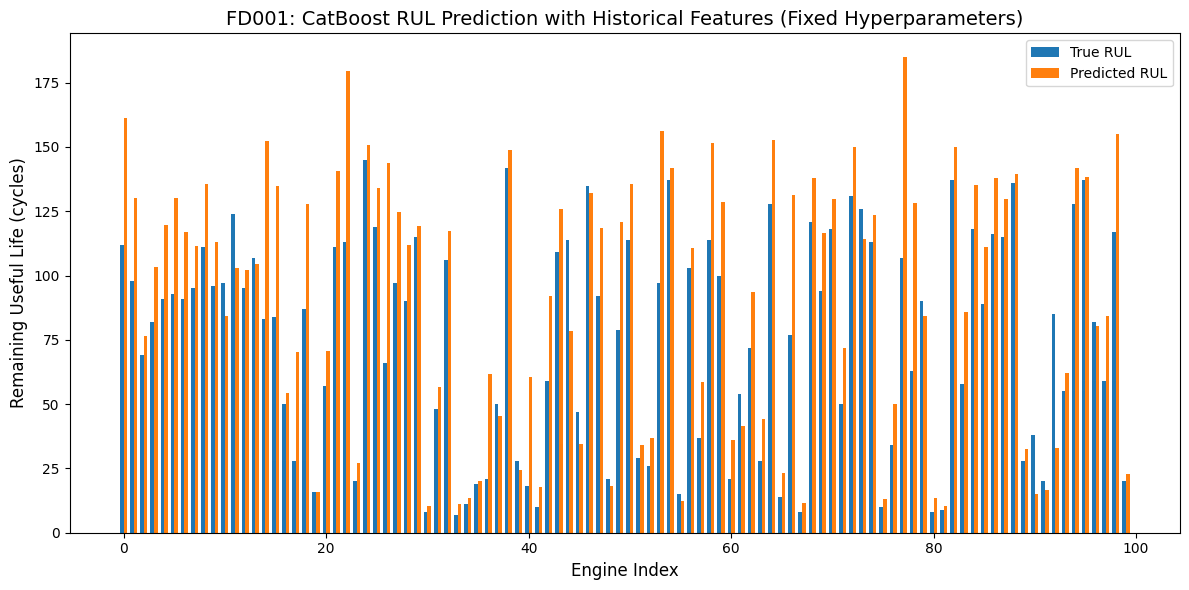

In [13]:
import catboost as cb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Dataset loading 
gb_train = datasets["FD001"]["train"]
gb_test = datasets["FD001"]["test"]
gb_RUL = datasets["FD001"]["rul"]

# Historical feature creation functions 
def create_history_features(df, feature_cols, window_size):
    X_hist = []
    y_hist = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) < window_size:
            continue
        for i in range(window_size - 1, len(group)):
            window_data = group.iloc[i - window_size + 1 : i + 1][feature_cols].values
            window_flat = window_data.flatten()
            target = group.iloc[i]["RUL"]
            X_hist.append(window_flat)
            y_hist.append(target)
    return np.array(X_hist), np.array(y_hist)

def create_test_history_features(df, feature_cols, window_size):
    X_test_hist = []
    unit_ids = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) >= window_size:
            window_data = group.iloc[-window_size:][feature_cols].values
            window_flat = window_data.flatten()
            X_test_hist.append(window_flat)
            unit_ids.append(unit)
    return np.array(X_test_hist), unit_ids

# Window size
window_size = 20

# Define feature columns 
feature_cols = [col for col in gb_train.columns if col not in ["unit_number", "time_cycles", "RUL"]]

# Create train/test sets
X_train_hist, y_train_hist = create_history_features(gb_train, feature_cols, window_size)
X_test_hist, test_unit_ids = create_test_history_features(gb_test, feature_cols, window_size)
y_test = gb_RUL["RUL"].values

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

# CatBoost Regressor with fixed hyperparameters
catboost_model = cb.CatBoostRegressor(
    iterations=200,
    depth=7,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bylevel=0.9,
    random_seed=42,
    verbose=0
)

catboost_model.fit(X_train_scaled, y_train_hist)

# Predict and evaluate
y_pred = catboost_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print("FD001 CatBoost Regressor Results with Fixed Hyperparameters:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Bar chart
n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: CatBoost RUL Prediction with Historical Features (Fixed Hyperparameters)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Best result we have found on gradient boosting  were XGBoost with historical data in mind and done scaling and its been used best hyperparameters

FD001 XGBoost Regressor Results with Fixed Hyperparameters:
Mean Absolute Error (MAE): 19.528961181640625
Root Mean Squared Error (RMSE): 26.353887849521488
R² Score: 0.5978112816810608

# HISTORICAL DATA WITH RANDOM FOREST

FD001 Random Forest Regressor Results with Fixed Hyperparameters:
Mean Absolute Error (MAE): 20.535154648999494
Root Mean Squared Error (RMSE): 27.64518448748043
R² Score: 0.5574325789585799


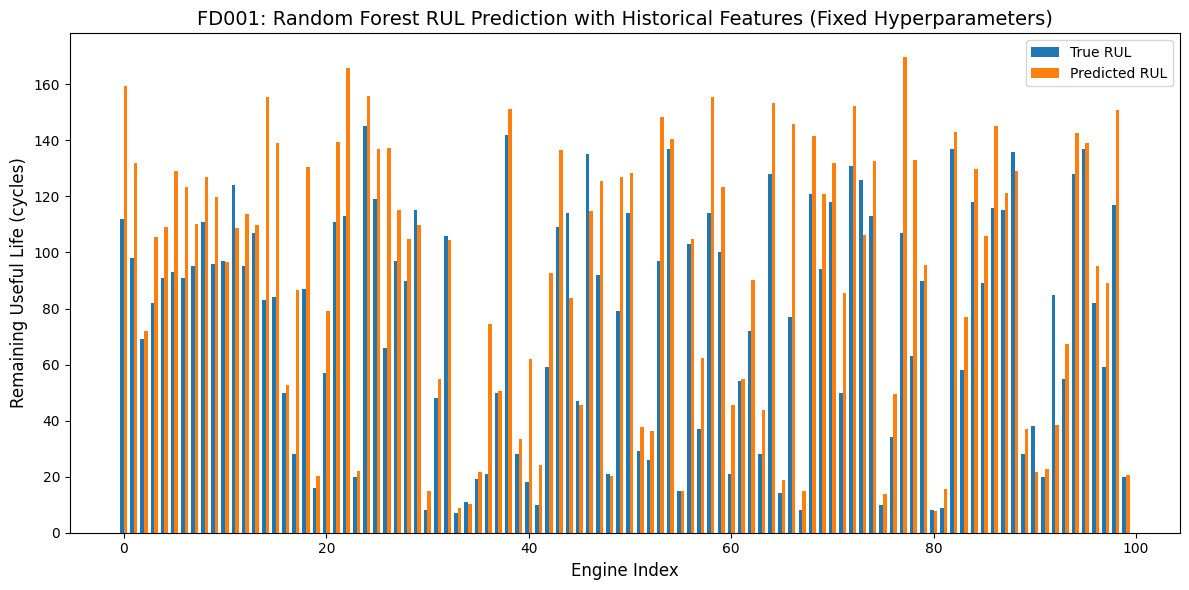

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Dataset loading 
rf_train = datasets["FD001"]["train"]
rf_test = datasets["FD001"]["test"]
rf_RUL = datasets["FD001"]["rul"]

# Historical feature creation functions 
def create_history_features(df, feature_cols, window_size):
    X_hist = []
    y_hist = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) < window_size:
            continue
        for i in range(window_size - 1, len(group)):
            window_data = group.iloc[i - window_size + 1 : i + 1][feature_cols].values
            window_flat = window_data.flatten()
            target = group.iloc[i]["RUL"]
            X_hist.append(window_flat)
            y_hist.append(target)
    return np.array(X_hist), np.array(y_hist)

def create_test_history_features(df, feature_cols, window_size):
    X_test_hist = []
    unit_ids = []
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) >= window_size:
            window_data = group.iloc[-window_size:][feature_cols].values
            window_flat = window_data.flatten()
            X_test_hist.append(window_flat)
            unit_ids.append(unit)
    return np.array(X_test_hist), unit_ids

window_size = 20
feature_cols = [col for col in rf_train.columns if col not in ["unit_number", "time_cycles", "RUL"]]

# Create train/test sets
X_train_hist, y_train_hist = create_history_features(rf_train, feature_cols, window_size)
X_test_hist, test_unit_ids = create_test_history_features(rf_test, feature_cols, window_size)
y_test = rf_RUL["RUL"].values

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

# Train Random Forest Regressor with fixed best hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_hist)

# Predict and evaluate
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print("FD001 Random Forest Regressor Results with Fixed Hyperparameters:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Bar chart
n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: Random Forest RUL Prediction with Historical Features (Fixed Hyperparameters)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


We got similar results to gradient booost on random forest after we used historical data